In [1]:
import flexynesis 
import torch, os
torch.set_num_threads(4)

In [ ]:
# parameters cell (required to pass arguments to the notebook) (see View -> show right sidebar -> add tag -> parameters)
HPO_ITER = 20 

In [2]:
if not os.path.exists("neuroblastoma"):
    !wget -O neuroblastoma.tgz "https://bimsbstatic.mdc-berlin.de/akalin/buyar/flexynesis-benchmark-datasets/neuroblastoma.tgz" && tar -xzvf neuroblastoma.tgz

--2024-02-06 14:14:24--  https://bimsbstatic.mdc-berlin.de/akalin/buyar/flexynesis-benchmark-datasets/neuroblastoma.tgz
Resolving bimsbstatic.mdc-berlin.de (bimsbstatic.mdc-berlin.de)... 141.80.181.47, 141.80.181.46
Connecting to bimsbstatic.mdc-berlin.de (bimsbstatic.mdc-berlin.de)|141.80.181.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128239759 (122M) [application/octet-stream]
Saving to: ‘neuroblastoma.tgz’

neuroblastoma.tgz   100%[===================>] 122.30M  5.85MB/s    in 21s     

2024-02-06 14:14:45 (5.87 MB/s) - ‘neuroblastoma.tgz’ saved [128239759/128239759]

neuroblastoma/
neuroblastoma/train/
neuroblastoma/train/clin.csv
neuroblastoma/train/gex.csv
neuroblastoma/9606.protein.aliases.v12.0.txt
neuroblastoma/test/
neuroblastoma/test/gex.csv
neuroblastoma/test/clin.csv
neuroblastoma/9606.protein.links.v12.0.txt


In [3]:
data_importer = flexynesis.DataImporter(path ='./neuroblastoma/', 
                                       data_types = ['gex'], 
                                        min_features=1000, top_percentile=100)
train_dataset, test_dataset = data_importer.import_data()


[INFO] ================= Importing Data =================
[INFO] Validating data folders...

[INFO] ----------------- Reading Data -----------------
[INFO] Importing ./neuroblastoma/train/clin.csv...
[INFO] Importing ./neuroblastoma/train/gex.csv...

[INFO] ----------------- Reading Data -----------------
[INFO] Importing ./neuroblastoma/test/clin.csv...
[INFO] Importing ./neuroblastoma/test/gex.csv...

[INFO] ---------- Processing Data (train) ----------

[INFO] --------------- Cleaning Up Data ---------------
Imputing NA values to median of features, affected # of features  31079  # of rows: 16557


100%|██████████| 16557/16557 [00:04<00:00, 3482.92it/s]


Number of NA values:  0
[INFO] DataFrame gex - Removed 474 features.
DataFrame gex - Removed 0 samples (0.00%).
Implementing feature selection using laplacian score for layer: gex with  16961 features
Returning original matrix, demanded # of features is  larger than existing number of features

[INFO] ---------- Processing Data (test) ----------

[INFO] --------------- Cleaning Up Data ---------------
Imputing NA values to median of features, affected # of features  19  # of rows: 13


100%|██████████| 13/13 [00:00<00:00, 2136.26it/s]


Number of NA values:  0
[INFO] DataFrame gex - Removed 676 features.
DataFrame gex - Removed 0 samples (0.00%).

[INFO] ------------ Harmonizing Data Sets ------------

[INFO] --------------- Normalizing Data ---------------

[INFO] --------------- Normalizing Data ---------------
[INFO] Training Data Stats:
 {'feature_count in: gex': 16686, 'sample_count': 139}
[INFO] Test Data Stats:
 {'feature_count in: gex': 16686, 'sample_count': 35}
[INFO] Data import successful.


In [4]:
flexynesis.print_summary_stats(train_dataset)

Summary for variable: disease
Categorical Variable Summary:
  Label: Neuroblastoma, Count: 139
------
Summary for variable: mycn
Categorical Variable Summary:
  Label: MYCN_amp, Count: 37
  Label: other, Count: 102
------
Summary for variable: subtype
Categorical Variable Summary:
  Label: High, Count: 23
  Label: Intermediate, Count: 29
  Label: Low, Count: 36
  Label: Unknown, Count: 28
  Label: nan, Count: 23
------
Summary for variable: dataset
Categorical Variable Summary:
  Label: DEPMAP, Count: 23
  Label: TARGET, Count: 116
------


In [5]:
tuner = flexynesis.HyperparameterTuning(train_dataset, 
                                        model_class = flexynesis.supervised_vae, 
                                        target_variables = ["mycn"],
                                        batch_variables = ["dataset"],
                                        config_name = "supervised_vae", 
                                        n_iter=HPO_ITER, plot_losses=True, early_stop_patience=20)

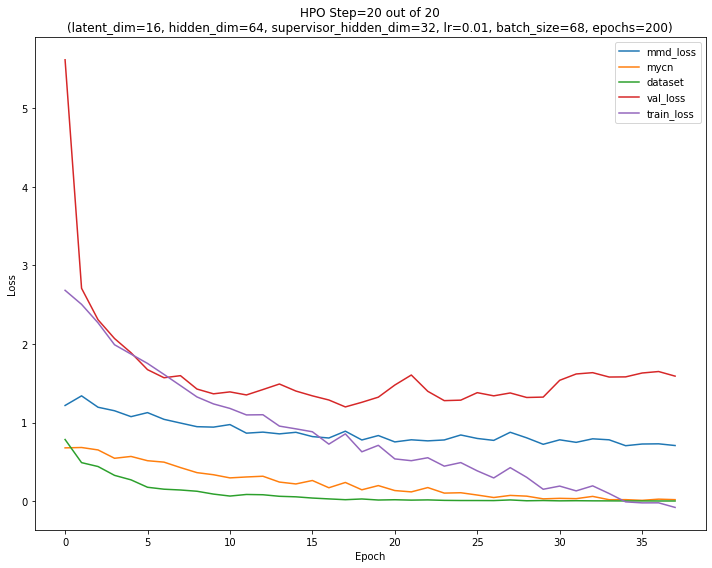

Monitored metric val_loss did not improve in the last 20 records. Best score: 1.200. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          dataset          │   0.002598179504275322    │
│         mmd_loss          │    0.6897986531257629     │
│           mycn            │    1.0517784357070923     │
│         val_loss          │    1.7441751956939697     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 20/20 [09:39<00:00, 28.97s/it, Iteration=20, Best Loss=1.18]


{'latent_dim': 16,
 'hidden_dim': 277,
 'supervisor_hidden_dim': 8,
 'lr': 0.01,
 'batch_size': 52,
 'epochs': 200}

In [6]:
model, best_params = tuner.perform_tuning()
best_params

In [7]:
y_pred_dict = model.predict(test_dataset)

In [8]:
metrics_df = flexynesis.evaluate_wrapper(y_pred_dict, test_dataset)
metrics_df

,var,variable_type,metric,value
0,mycn,categorical,balanced_acc,0.895833
1,mycn,categorical,f1_score,0.849268
2,mycn,categorical,kappa,0.704890
3,dataset,categorical,balanced_acc,1.000000
4,dataset,categorical,f1_score,1.000000
5,dataset,categorical,kappa,1.000000


In [9]:
ds = train_dataset
E = model.transform(ds)

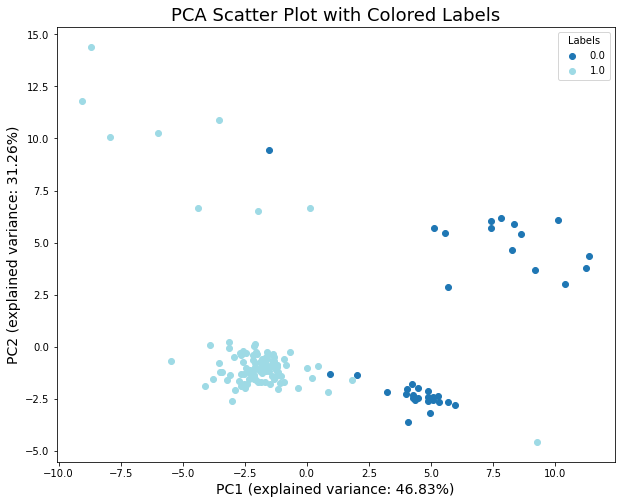

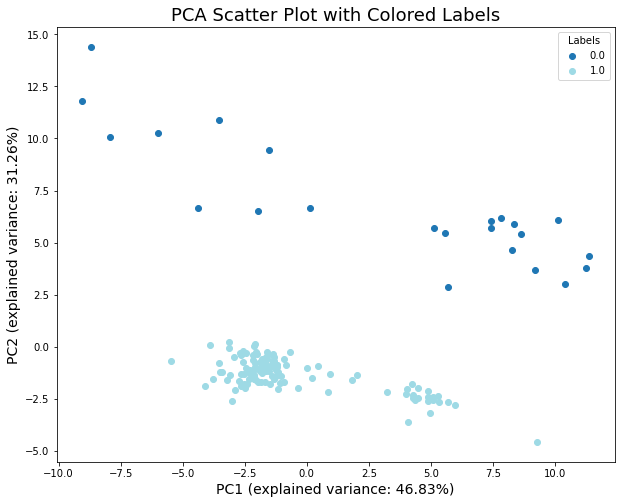

(None, None)

In [10]:
flexynesis.plot_dim_reduced(E, labels = ds.ann['mycn'].numpy()), flexynesis.plot_dim_reduced(E, labels = ds.ann['dataset'].numpy())

In [15]:
E2 = flexynesis.remove_batch_associated_variables(data = E, variable_types=ds.variable_types, 
                                                  target_dict = {x: train_dataset.ann[x] for x in model.target_variables},
                                                  batch_dict= {x:train_dataset.ann[x] for x in model.batch_variables}, mi_threshold=0.2)

In [16]:
E.shape, E2.shape

((139, 16), (139, 4))

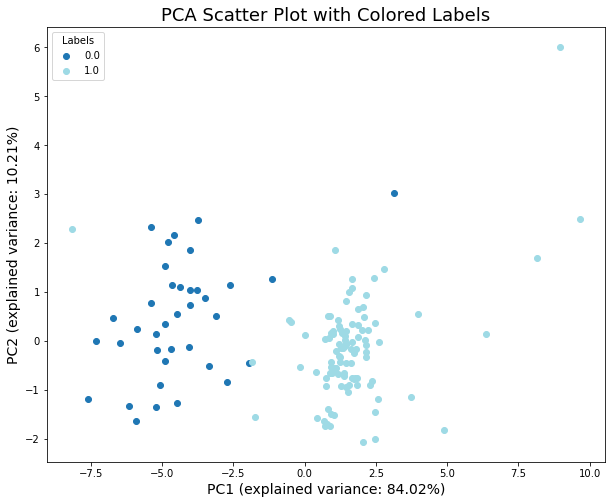

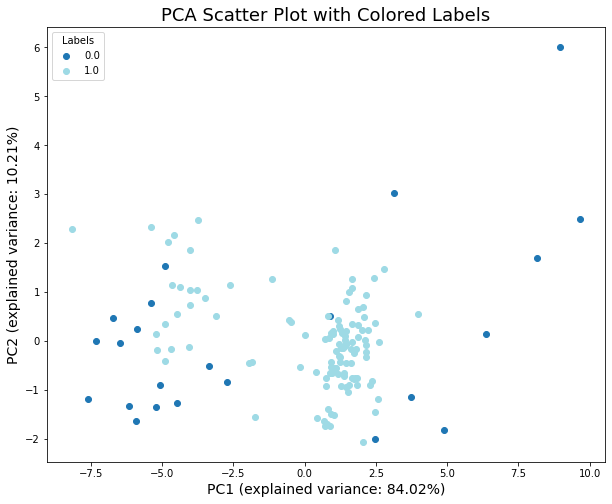

(None, None)

In [17]:
flexynesis.plot_dim_reduced(E2, labels = ds.ann['mycn'].numpy()), flexynesis.plot_dim_reduced(E2, labels = ds.ann['dataset'].numpy())